<a href="https://colab.research.google.com/github/ChiThang-50Cent/Air_pollution_forcasting/blob/main/Air_Pollution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Spark, BigDL

In [2]:
!wget https://raw.githubusercontent.com/ChiThang-50Cent/Air_pollution_forcasting/main/Air_pollution.csv

--2024-01-20 16:26:20--  https://raw.githubusercontent.com/ChiThang-50Cent/Air_pollution_forcasting/main/Air_pollution.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2301672 (2.2M) [text/plain]
Saving to: ‘Air_pollution.csv.1’

Air_pollution.csv.1 100%[===================>]   2.19M  --.-KB/s    in 0.06s   

2024-01-20 16:26:20 (34.2 MB/s) - ‘Air_pollution.csv.1’ saved [2301672/2301672]



In [ ]:
!pip install --pre --upgrade bigdl-chronos[pytorch]
!pip uninstall -y torchtext

!pip install pyspark

import os
os.kill(os.getpid(), 9)

# Preprocessing

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import udf
from pyspark.sql import types

import pandas as pd

In [2]:
spark = SparkSession.builder.master("local[1]")\
          .appName("Air_Pollution")\
          .getOrCreate()

In [3]:
df = spark.read.option("header",True).csv("/content/Air_pollution.csv")

In [4]:
df.show(5)

+-------------------+---------+---+----+------+-------+-------+----+----+
|               date|pollution|dew|temp| press|wnd_dir|wnd_spd|snow|rain|
+-------------------+---------+---+----+------+-------+-------+----+----+
|2010-01-02 00:00:00|    129.0|-16|-4.0|1020.0|     SE|   1.79|   0|   0|
|2010-01-02 01:00:00|    148.0|-15|-4.0|1020.0|     SE|   2.68|   0|   0|
|2010-01-02 02:00:00|    159.0|-11|-5.0|1021.0|     SE|   3.57|   0|   0|
|2010-01-02 03:00:00|    181.0| -7|-5.0|1022.0|     SE|   5.36|   1|   0|
|2010-01-02 04:00:00|    138.0| -7|-5.0|1022.0|     SE|   6.25|   2|   0|
+-------------------+---------+---+----+------+-------+-------+----+----+
only showing top 5 rows



In [5]:
df.dtypes

[('date', 'string'),
 ('pollution', 'string'),
 ('dew', 'string'),
 ('temp', 'string'),
 ('press', 'string'),
 ('wnd_dir', 'string'),
 ('wnd_spd', 'string'),
 ('snow', 'string'),
 ('rain', 'string')]

In [6]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+----+---------+---+----+-----+-------+-------+----+----+
|date|pollution|dew|temp|press|wnd_dir|wnd_spd|snow|rain|
+----+---------+---+----+-----+-------+-------+----+----+
|   0|        0|  0|   0|    0|      0|      0|   0|   0|
+----+---------+---+----+-----+-------+-------+----+----+



## Type Casting

In [7]:
df = df.withColumn("pollution",col("pollution").cast("float"))
df = df.withColumn("dew",col("dew").cast("int"))
df = df.withColumn("temp",col("temp").cast("float"))
df = df.withColumn("press",col("press").cast("float"))
df = df.withColumn("wnd_spd",col("wnd_spd").cast("float"))
df = df.withColumn("snow",col("snow").cast("int"))
df = df.withColumn("rain",col("rain").cast("int"))

In [8]:
mapping = {'NE': 0, 'SE': 1, 'NW': 2, 'cv': 3}
mapp = udf(lambda x: mapping[x], types.IntegerType())

df = df.withColumn("wnd_dir", mapp(col('wnd_dir')))

In [9]:
df.show(5)

+-------------------+---------+---+----+------+-------+-------+----+----+
|               date|pollution|dew|temp| press|wnd_dir|wnd_spd|snow|rain|
+-------------------+---------+---+----+------+-------+-------+----+----+
|2010-01-02 00:00:00|    129.0|-16|-4.0|1020.0|      1|   1.79|   0|   0|
|2010-01-02 01:00:00|    148.0|-15|-4.0|1020.0|      1|   2.68|   0|   0|
|2010-01-02 02:00:00|    159.0|-11|-5.0|1021.0|      1|   3.57|   0|   0|
|2010-01-02 03:00:00|    181.0| -7|-5.0|1022.0|      1|   5.36|   1|   0|
|2010-01-02 04:00:00|    138.0| -7|-5.0|1022.0|      1|   6.25|   2|   0|
+-------------------+---------+---+----+------+-------+-------+----+----+
only showing top 5 rows



In [10]:
pd_df = df.toPandas()

In [11]:
pd_df['date'] = pd.to_datetime(pd_df['date'])

In [12]:
pd_df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,1,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,1,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,1,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,1,6.25,2,0


# EDA

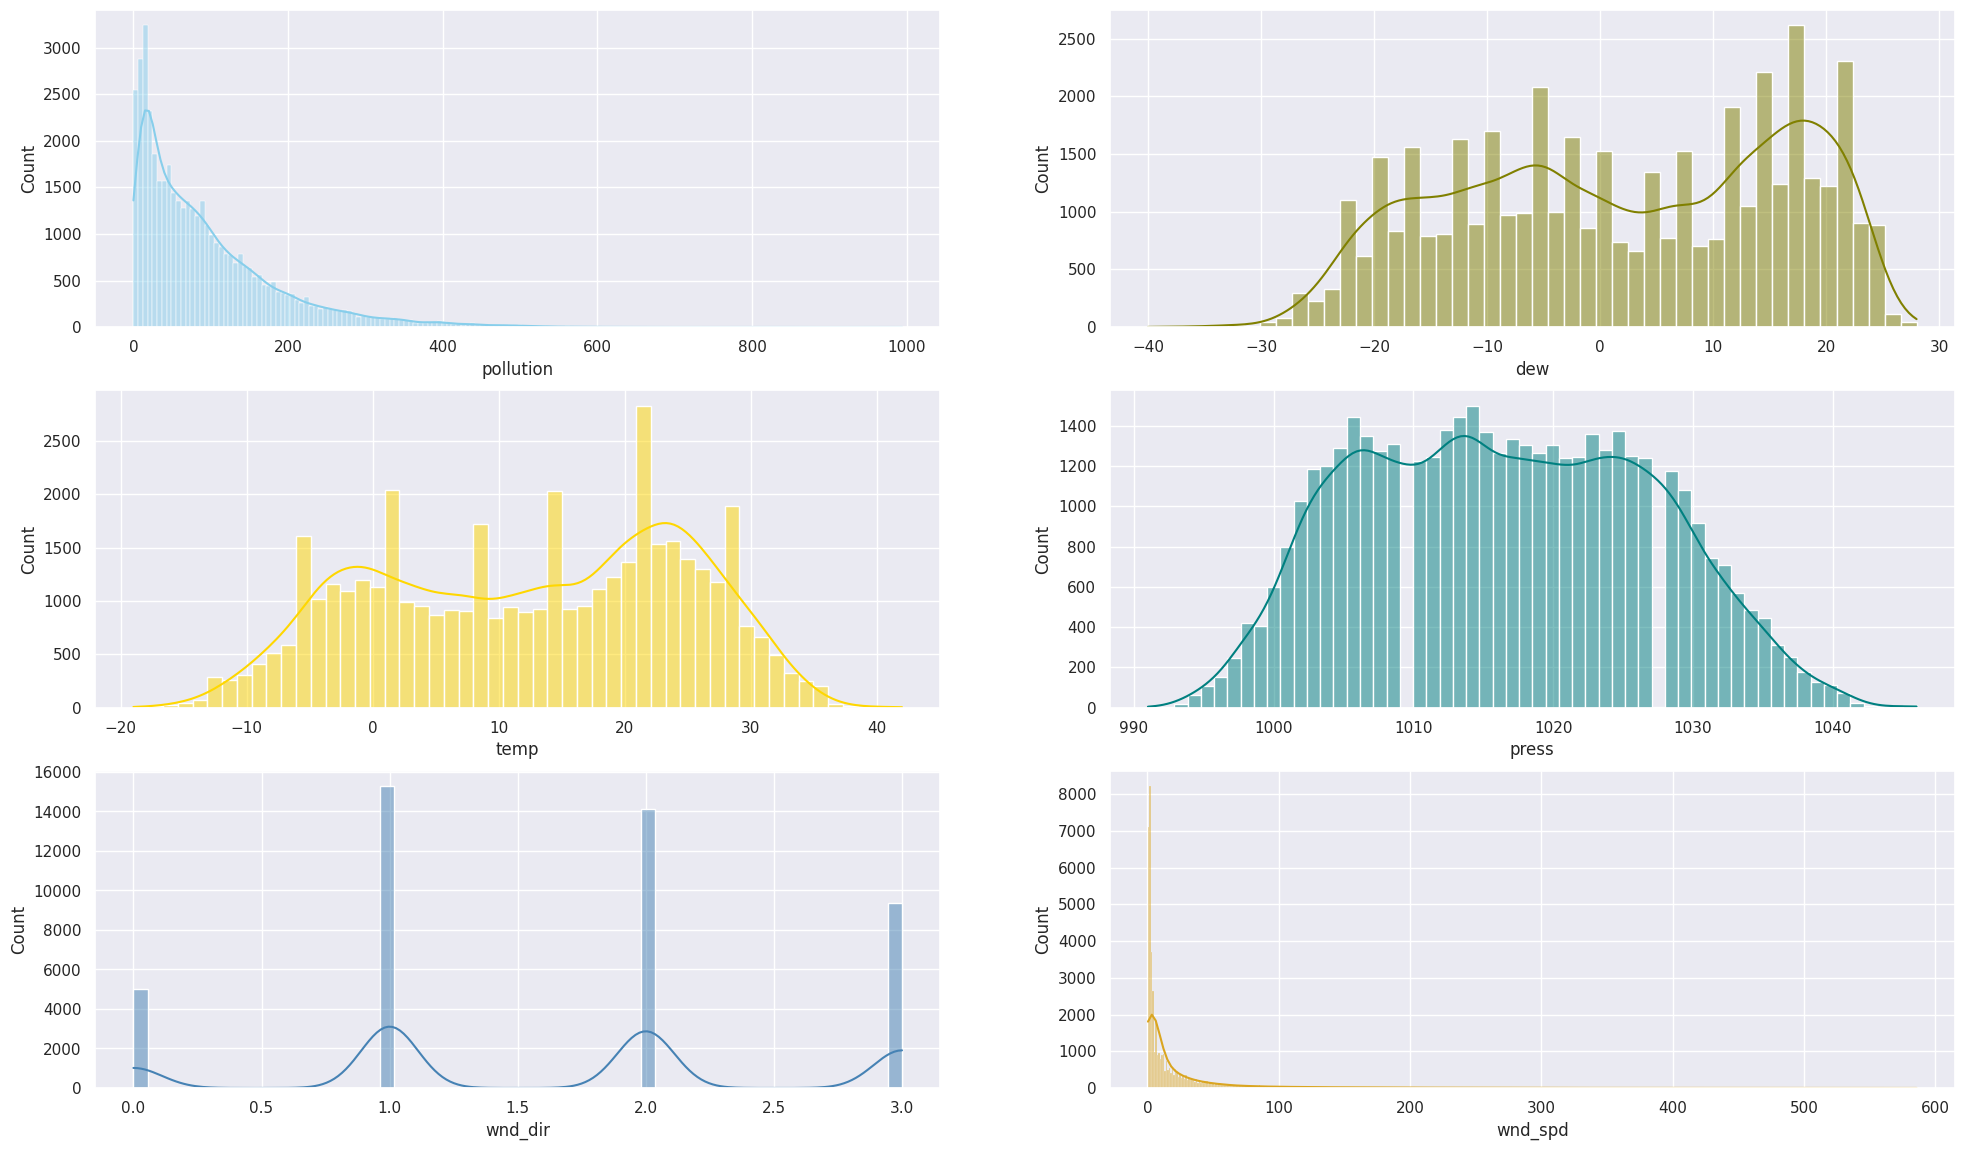

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

df_train_scaled = pd_df.copy()

sns.set(style="darkgrid")

fig, axs = plt.subplots(3,2, figsize=(24,14))

sns.histplot(data=df_train_scaled, x="pollution", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df_train_scaled, x="dew", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df_train_scaled, x="temp", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=df_train_scaled, x="press", kde=True, color="teal", ax=axs[1, 1])
sns.histplot(data=df_train_scaled, x="wnd_dir", kde=True, color="steelblue", ax=axs[2, 0])
sns.histplot(data=df_train_scaled, x="wnd_spd", kde=True, color="goldenrod", ax=axs[2, 1])

plt.savefig("/content/figures/eda.png")

# Gen Dataset

In [14]:
look_back = 168
horizon = 1

In [15]:
def gen_train_test_tsdata(df, dt_col, target_col, ex_col):
  from bigdl.chronos.data import TSDataset
  from sklearn.preprocessing import StandardScaler

  tsdata_train, _, tsdata_test = TSDataset\
  .from_pandas(df, dt_col=dt_col,
               target_col=target_col,
               extra_feature_col=ex_col,
               with_split=True,
               test_ratio=0.1)

  standard_scaler = StandardScaler()

  for tsdata in [tsdata_train, tsdata_test]:
    tsdata.repair_abnormal_data()
    tsdata.gen_dt_feature()\
          .impute(mode="last")\
          .scale(standard_scaler, fit=(tsdata is tsdata_train))

  for tsdata in [tsdata_train, tsdata_test]:
    tsdata.roll(lookback=look_back, horizon=horizon, target_col=target_col)

  return tsdata_train, tsdata_test

In [16]:
def get_numpy_data(tsdata_train, tsdata_test):
  x_train, y_train = tsdata_train.to_numpy()
  x_test, y_test = tsdata_test.to_numpy()

  return x_train, y_train, x_test, y_test

# Model & Train

In [17]:
def init_model(x_train, y_train):
  from bigdl.chronos.forecaster.lstm_forecaster import LSTMForecaster
  from bigdl.chronos.forecaster.seq2seq_forecaster import Seq2SeqForecaster
  from bigdl.chronos.forecaster.tcn_forecaster import TCNForecaster

  LSTM_forecaster = LSTMForecaster(past_seq_len=x_train.shape[1],
                                 input_feature_num=x_train.shape[-1],
                                 output_feature_num=y_train.shape[-1],
                                 layer_num=2,
                                 dropout = 0.1,
                                 lr=1e-3)

  TCN_forecaster = TCNForecaster(past_seq_len = look_back,
                                future_seq_len = horizon,
                                input_feature_num = x_train.shape[-1],
                                output_feature_num = y_train.shape[-1],
                                kernel_size = 3,
                                dropout = 0.1,
                                lr = 0.001)

  S2S_forecaster = Seq2SeqForecaster(past_seq_len = look_back,
                                future_seq_len = horizon,
                                input_feature_num = x_train.shape[-1],
                                output_feature_num = y_train.shape[-1],
                                dropout = 0.1,
                                lr = 0.001)

  return [LSTM_forecaster, TCN_forecaster, S2S_forecaster]

In [18]:
def train_model(list_model, x_train, y_train):
  from IPython.display import clear_output

  for i in range(len(list_model)):
    clear_output(wait=True)
    list_model[i].fit((x_train, y_train), epochs=1, batch_size=512)

  return list_model

In [19]:
def save_model(model, title):
  model.save(f'/content/saved_models/{title}.txt')

In [38]:
def load_model(model, title):
  model.load(f'/content/saved_models/{title}.txt')

  return model

# Evaluation

In [21]:
def get_prediction(tsdata_test, x_test, y_test, model):
  pred_lstm = model.predict(x_test)
  pred_unscale = tsdata_test.unscale_numpy(pred_lstm)
  groundtruth_unscale = tsdata_test.unscale_numpy(y_test)

  return pred_unscale, groundtruth_unscale

In [22]:
def evaluation(y_true, y_pred):
  from bigdl.chronos.metric.forecast_metrics import Evaluator

  list_metric = Evaluator.evaluate(['mae', 'rmse', 'r2'], y_true, y_pred)

  return list_metric

In [23]:
def get_prediction_chart(pred_unscale, groundtruth_unscale, num_of_sample, title="Forecasting"):
  import matplotlib.pyplot as plt
  plt.style.use('ggplot')

  plt.figure(figsize=(24,6))
  plt.plot(pred_unscale[:,:,0][:num_of_sample])
  plt.plot(groundtruth_unscale[:,:,0][:num_of_sample])
  plt.legend(["prediction", "ground truth"])
  plt.title(title)
  plt.savefig(f'/content/figures/{title}.png')

# Main

In [24]:
def main(df):
  list_ex_col = [[], ['dew', 'temp', 'press'], ['wnd_dir', 'wnd_spd', 'snow', 'rain']]
  res = {}

  for col in list_ex_col:
    tsdata_train, tsdata_test = gen_train_test_tsdata(df, 'date', 'pollution', col)
    x_train, y_train, x_test, y_test = get_numpy_data(tsdata_train, tsdata_test)

    list_models = init_model(x_train, y_train)
    list_models = train_model(list_models, x_train, y_train)

    for i, models in enumerate(list_models):
      cols_name = '_'.join(col)
      models_name = ''

      if i == 0:
        models_name = 'LSTM_Forecaster'
      elif i == 1:
        models_name = 'TCN_Forecaster'
      else:
        models_name = 'Seq2Seq_Forecaster'

      title = f'{models_name}_{cols_name}'

      pred_unscale, groundtruth_unscale = get_prediction(tsdata_test, x_test, y_test, models)
      list_metrics = evaluation(groundtruth_unscale, pred_unscale)
      get_prediction_chart(pred_unscale, groundtruth_unscale, 500, title)

      res[title] = list_metrics

      save_model(models, title)

  return res

In [ ]:
res = main(pd_df)

In [34]:
res_df = pd.DataFrame(res)

In [35]:
res_df = res_df.transpose()
res_df.columns = ['mae', 'rmse', 'r2']
res_df

,mae,rmse,r2
LSTM_Forecaster_,10.982537,21.688320,0.935231
TCN_Forecaster_,11.474941,21.646841,0.935479
Seq2Seq_Forecaster_,10.928048,21.683656,0.935259
LSTM_Forecaster_dew_temp_press,11.020833,21.386042,0.937024
TCN_Forecaster_dew_temp_press,11.552870,21.762815,0.934786
Seq2Seq_Forecaster_dew_temp_press,10.856399,21.280519,0.937644
LSTM_Forecaster_wnd_dir_wnd_spd_snow_rain,11.036987,21.671739,0.935330
TCN_Forecaster_wnd_dir_wnd_spd_snow_rain,11.246380,21.564618,0.935968
Seq2Seq_Forecaster_wnd_dir_wnd_spd_snow_rain,11.170516,21.688809,0.935228


from matplotlib import pyplot as plt
res_df['mae'].plot(kind='hist', bins=20, title='mae')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_df['rmse'].plot(kind='hist', bins=20, title='rmse')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_df['r2'].plot(kind='hist', bins=20, title='r2')
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


from matplotlib import pyplot as plt
res_df.plot(kind='scatter', x='mae', y='rmse', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


from matplotlib import pyplot as plt
res_df.plot(kind='scatter', x='rmse', y='r2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_df['mae'].plot(kind='line', figsize=(8, 4), title='mae')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
res_df['rmse'].plot(kind='line', figsize=(8, 4), title='rmse')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
res_df['r2'].plot(kind='line', figsize=(8, 4), title='r2')
plt.gca().spines[['top', 'right']].set_visible(False)

In [46]:
def i_d_n_to_name_it(df):
  list_ex_col = [[], ['dew', 'temp', 'press'], ['wnd_dir', 'wnd_spd', 'snow', 'rain']]

  result = []
  y_true = None

  for col in list_ex_col:
    tsdata_train, tsdata_test = gen_train_test_tsdata(df, 'date', 'pollution', col)
    x_train, y_train, x_test, y_test = get_numpy_data(tsdata_train, tsdata_test)

    list_models = init_model(x_train, y_train)

    for i, model in enumerate(list_models):
      cols_name = '_'.join(col)
      models_name = ''

      if i == 0:
        models_name = 'LSTM_Forecaster'
      elif i == 1:
        models_name = 'TCN_Forecaster'
      else:
        models_name = 'Seq2Seq_Forecaster'

      title = f'{models_name}_{cols_name}'

      model = load_model(model, title)
      pred_unscale, groundtruth_unscale = get_prediction(tsdata_test, x_test, y_test, model)

      result.append([title, pred_unscale])
      y_true = groundtruth_unscale

  return result, y_true

In [47]:
result, y_true = i_d_n_to_name_it(pd_df)

INFO:pytorch_lightning.utilities.seed:Global seed set to 1234367164
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234367164
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


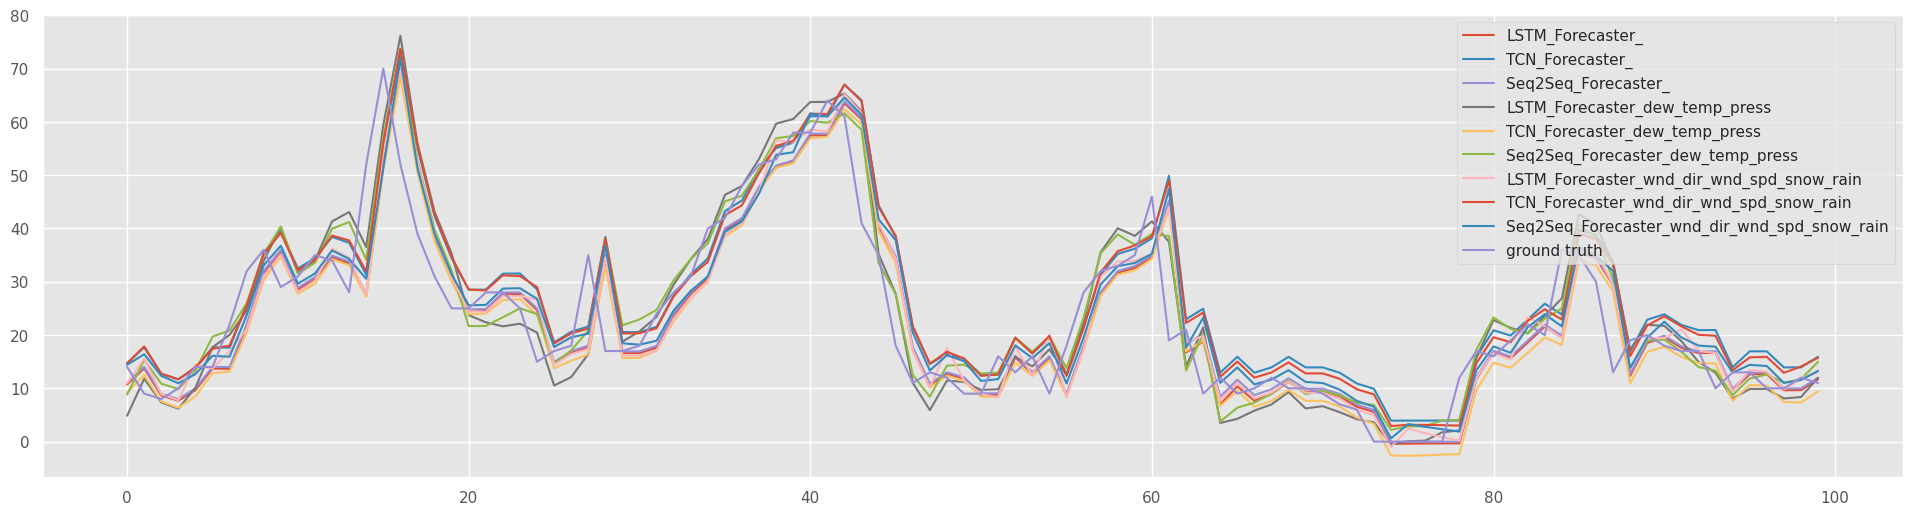

In [48]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

legend = []
plt.figure(figsize=(24,6))

for res in result:
  title = res[0]
  y_pred = res[1]

  legend.append(title)

  plt.plot(y_pred[:,:,0][:100])

plt.plot(y_true[:,:,0][:100])
plt.legend([*legend, "ground truth"])

plt.show()